In [1]:
# Import libraries
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neighbors as skn
from sklearn.exceptions import ConvergenceWarning
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]
lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
subsc = subject_id_corr

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [5]:
scoring = 'r2'
r = 1
results_bls = np.zeros_like(per_change)
results_ls = np.zeros(r*len(per_change))
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-5,-3,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []

In [7]:
Js = []
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
    cvn = 10
    # Resample to avoid stratification errors
    while np.sum(y_cat) < cvn:
      idyr = np.random.choice(np.asarray(idy).ravel())
      X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
      y_train = np.append(y_train,y_train[idyr])
      y_cat = y_train <= 0.3
      
    for k in np.arange(r):
      skf_g = sms.StratifiedKFold(n_splits=cvn,shuffle=True,random_state=k)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=1000,cv=skf_gen)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X_test_sst = sel.transform(X_test_ss0)
        X_smogn,y_smogn,idxk,sscaler = util.rad_smogn(X0_sst,y_train,np.min(y_train),np.median(y_train),1,0,0.5,0.2)
        X0_ss = np.vstack((X0_sst,X_smogn))
        y_train = np.hstack((y_train,y_smogn))
        X_smogn,y_smogn,idxk,sscaler = util.rad_smogn(X0_ss,y_train,np.min(y_train),np.median(y_train),1,0,0.5,0.2)
        X0_ss = np.vstack((X0_ss,X_smogn))
        y_train = np.hstack((y_train,y_smogn))
        X_test_ss = X_test_sst
        dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
      results_ls[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls[c],4)),
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)))
    
      c=c+1

        

  


Prior to SMOGN sampling, mean is -0.00022618759167442574 standard deviation is 0.9563718354509787


r_index: 100%|##########| 2/2 [00:00<00:00,  5.54it/s]


Prior to SMOGN sampling, mean is 0.05826026866713419 standard deviation is 0.9398494112464955


r_index: 100%|##########| 2/2 [00:00<00:00, 16.05it/s]


Lasso predicts 0.7023 for case with 0.72
Prior to SMOGN sampling, mean is 0.003029150952347568 standard deviation is 0.8768078998782638


synth_matrix: 100%|##########| 11/11 [00:00<00:00, 24.28it/s]


Prior to SMOGN sampling, mean is 0.038093635406525765 standard deviation is 0.8338913196739561


r_index: 100%|##########| 17/17 [00:00<00:00, 40.03it/s]


Lasso predicts 0.5114 for case with 0.47
Prior to SMOGN sampling, mean is 0.005833521559395042 standard deviation is 0.9253295516159236


r_index: 100%|##########| 2/2 [00:00<00:00,  4.61it/s]


Prior to SMOGN sampling, mean is 0.06036821672430718 standard deviation is 0.9157367568994988


r_index: 100%|##########| 16/16 [00:03<00:00,  4.15it/s]


Lasso predicts 0.7591 for case with 0.69
Prior to SMOGN sampling, mean is 0.0004581363426300526 standard deviation is 0.9295108338147758


synth_matrix: 100%|##########| 11/11 [00:01<00:00,  6.66it/s]


Prior to SMOGN sampling, mean is 0.038582023968335835 standard deviation is 0.9198666383198942


r_index: 100%|##########| 2/2 [00:00<00:00,  8.47it/s]


Lasso predicts 0.6522 for case with 0.42
Prior to SMOGN sampling, mean is -0.007698993689956977 standard deviation is 0.9138529712348196


r_index: 100%|##########| 2/2 [00:01<00:00,  1.80it/s]


Prior to SMOGN sampling, mean is 0.001152932291930431 standard deviation is 0.8773494917267611


r_index: 100%|##########| 17/17 [00:02<00:00,  6.86it/s]


Lasso predicts 0.3775 for case with 0.15
Prior to SMOGN sampling, mean is -0.0036960847058148836 standard deviation is 0.9417384034306958


synth_matrix: 100%|##########| 11/11 [00:05<00:00,  2.01it/s]


Prior to SMOGN sampling, mean is 0.040172847934719765 standard deviation is 0.9052301825567977


r_index: 100%|##########| 7/7 [00:02<00:00,  2.88it/s]


Lasso predicts 0.53 for case with 0.44
Prior to SMOGN sampling, mean is 0.012711895301952 standard deviation is 0.9363328130936893


r_index: 100%|##########| 2/2 [00:00<00:00,  8.70it/s]


Prior to SMOGN sampling, mean is 0.06739323120865129 standard deviation is 0.9271771971797147


r_index: 100%|##########| 16/16 [00:00<00:00, 17.95it/s]


Lasso predicts 0.6892 for case with 0.88
Prior to SMOGN sampling, mean is 0.004913904542791004 standard deviation is 0.8981640450481619


synth_matrix: 100%|##########| 11/11 [00:03<00:00,  2.81it/s]


Prior to SMOGN sampling, mean is 0.038884888431044366 standard deviation is 0.825724662686239


r_index: 100%|##########| 15/15 [00:03<00:00,  4.54it/s]


Lasso predicts 0.5307 for case with 0.4
Prior to SMOGN sampling, mean is 0.0031020688349128658 standard deviation is 0.8951950016404583


r_index: 100%|##########| 2/2 [00:01<00:00,  1.46it/s]


Prior to SMOGN sampling, mean is 0.02922278791516557 standard deviation is 0.8392789808176238


r_index: 100%|##########| 8/8 [00:02<00:00,  3.67it/s]


Lasso predicts 0.6178 for case with 0.6
Prior to SMOGN sampling, mean is 0.0006268944961808429 standard deviation is 0.9069110134019046


r_index: 100%|##########| 2/2 [00:00<00:00,  4.59it/s]


Prior to SMOGN sampling, mean is 0.031418905065406996 standard deviation is 0.8606982371300247


r_index: 100%|##########| 11/11 [00:02<00:00,  3.82it/s]


Lasso predicts 0.4313 for case with 0.81
Prior to SMOGN sampling, mean is 0.006071159825172921 standard deviation is 0.9381724932280177


r_index: 100%|##########| 2/2 [00:00<00:00,  8.86it/s]


Prior to SMOGN sampling, mean is 0.04944035629126349 standard deviation is 0.895233746898123


synth_matrix: 100%|##########| 19/19 [00:01<00:00, 14.90it/s]


Lasso predicts 0.6733 for case with 0.64
Prior to SMOGN sampling, mean is -0.003517827075474636 standard deviation is 0.9407531891545898


r_index: 100%|##########| 2/2 [00:00<00:00,  2.25it/s]


Prior to SMOGN sampling, mean is 0.025574557574524634 standard deviation is 0.8883443526398731


r_index: 100%|##########| 6/6 [00:01<00:00,  3.39it/s]


Lasso predicts 0.6158 for case with 0.72
Prior to SMOGN sampling, mean is -0.00046416909129615294 standard deviation is 0.9186275792979283


r_index: 100%|##########| 2/2 [00:01<00:00,  1.51it/s]


Prior to SMOGN sampling, mean is 0.030994067179709265 standard deviation is 0.8645212971626676


r_index: 100%|##########| 15/15 [00:03<00:00,  4.15it/s]


Lasso predicts 0.5833 for case with 0.31
Prior to SMOGN sampling, mean is 0.008997067137187757 standard deviation is 0.8859803307039009


r_index: 100%|##########| 2/2 [00:00<00:00, 22.56it/s]


Prior to SMOGN sampling, mean is 0.04594178028379458 standard deviation is 0.8447364734297581


r_index: 100%|##########| 13/13 [00:00<00:00, 39.58it/s]


Lasso predicts 0.4662 for case with 0.68
Prior to SMOGN sampling, mean is -0.002022555907437087 standard deviation is 0.9302865024743591


synth_matrix: 100%|##########| 11/11 [00:05<00:00,  1.93it/s]


Prior to SMOGN sampling, mean is 0.04036698081943775 standard deviation is 0.8990163430630597


r_index: 100%|##########| 2/2 [00:01<00:00,  1.73it/s]


Lasso predicts 0.3888 for case with 0.34
Prior to SMOGN sampling, mean is 0.0015131276470766214 standard deviation is 0.931977481624881


r_index: 100%|##########| 2/2 [00:00<00:00,  2.22it/s]


Prior to SMOGN sampling, mean is 0.03392921637070851 standard deviation is 0.8865384166257881


r_index: 100%|##########| 16/16 [00:03<00:00,  5.25it/s]


Lasso predicts 0.4743 for case with 0.59
Prior to SMOGN sampling, mean is 0.012417216538268072 standard deviation is 0.8881255973664945


r_index: 100%|##########| 2/2 [00:00<00:00, 33.59it/s]


Prior to SMOGN sampling, mean is 0.050123324067376976 standard deviation is 0.856745793489557


r_index: 100%|##########| 15/15 [00:00<00:00, 58.70it/s]


Lasso predicts 0.7067 for case with 0.94
Prior to SMOGN sampling, mean is 0.013193171659226656 standard deviation is 0.8908935675714956


r_index: 100%|##########| 2/2 [00:00<00:00, 66.87it/s]


Prior to SMOGN sampling, mean is 0.05122665777154884 standard deviation is 0.8537950848839942


r_index: 100%|##########| 15/15 [00:00<00:00, 66.03it/s]


Lasso predicts 0.7839 for case with 0.84
Prior to SMOGN sampling, mean is 0.009584082306713785 standard deviation is 0.984078248009551


r_index: 100%|##########| 10/10 [00:01<00:00,  5.10it/s]


Prior to SMOGN sampling, mean is 0.06093659533078473 standard deviation is 0.9849842272574981


r_index: 100%|##########| 11/11 [00:01<00:00,  7.53it/s]


Lasso predicts 0.4384 for case with 0.1
Prior to SMOGN sampling, mean is -0.0014120554492820915 standard deviation is 0.9196993593809196


synth_matrix: 100%|##########| 11/11 [00:05<00:00,  1.91it/s]


Prior to SMOGN sampling, mean is 0.028897482088832006 standard deviation is 0.880642700388619


r_index: 100%|##########| 17/17 [00:06<00:00,  2.61it/s]


Lasso predicts 0.4779 for case with 0.41
Prior to SMOGN sampling, mean is 0.018417346453539596 standard deviation is 0.950662432628722


r_index: 100%|##########| 2/2 [00:00<00:00,  4.79it/s]


Prior to SMOGN sampling, mean is 0.06148246281431052 standard deviation is 0.891103528850109


r_index: 100%|##########| 8/8 [00:00<00:00,  9.56it/s]


Lasso predicts 0.5674 for case with 0.57
Prior to SMOGN sampling, mean is 0.0010576558919551055 standard deviation is 0.933235258033548


r_index: 100%|##########| 2/2 [00:00<00:00,  7.14it/s]


Prior to SMOGN sampling, mean is 0.04607974981967567 standard deviation is 0.9149126534129804


r_index: 100%|##########| 16/16 [00:02<00:00,  5.74it/s]


Lasso predicts 0.6457 for case with 0.66
Prior to SMOGN sampling, mean is 0.006128135327013686 standard deviation is 0.9258845855672884


r_index: 100%|##########| 2/2 [00:00<00:00,  2.10it/s]


Prior to SMOGN sampling, mean is 0.05877022832046312 standard deviation is 0.9099284222019011


r_index: 100%|##########| 15/15 [00:04<00:00,  3.67it/s]


Lasso predicts 0.6217 for case with 0.63
Prior to SMOGN sampling, mean is 0.0063009905380531335 standard deviation is 0.9360849797487161


synth_matrix: 100%|##########| 11/11 [00:01<00:00,  8.46it/s]


Prior to SMOGN sampling, mean is 0.04981493211218959 standard deviation is 0.8816806457684372


r_index: 100%|##########| 2/2 [00:00<00:00,  8.79it/s]


Lasso predicts 0.5305 for case with 0.47
Prior to SMOGN sampling, mean is 0.006363144114449578 standard deviation is 0.9064160531042827


r_index: 100%|##########| 2/2 [00:00<00:00,  2.34it/s]


Prior to SMOGN sampling, mean is 0.04041209338436582 standard deviation is 0.8729133478916923


r_index: 100%|##########| 7/7 [00:00<00:00,  7.12it/s]


Lasso predicts 0.4012 for case with 0.28
Prior to SMOGN sampling, mean is -0.0023285945288948782 standard deviation is 0.9190034214671092


r_index: 100%|##########| 2/2 [00:01<00:00,  1.45it/s]


Prior to SMOGN sampling, mean is 0.038942281017911126 standard deviation is 0.8933415256612794


r_index: 100%|##########| 17/17 [00:04<00:00,  4.18it/s]


Lasso predicts 0.6408 for case with 0.59
Prior to SMOGN sampling, mean is 0.0030113874919287624 standard deviation is 0.9199789104042395


r_index: 100%|##########| 2/2 [00:00<00:00,  6.92it/s]


Prior to SMOGN sampling, mean is 0.04838241732231781 standard deviation is 0.886834174984751


r_index: 100%|##########| 11/11 [00:01<00:00,  5.97it/s]


Lasso predicts 0.5872 for case with 0.53
Prior to SMOGN sampling, mean is 0.0020482139740369667 standard deviation is 0.9015467940423089


r_index: 100%|##########| 2/2 [00:01<00:00,  1.21it/s]


Prior to SMOGN sampling, mean is 0.022257465646467002 standard deviation is 0.8335949735943379


r_index: 100%|##########| 10/10 [00:03<00:00,  3.17it/s]


Lasso predicts 0.6463 for case with 0.86
Prior to SMOGN sampling, mean is 0.0015526880403645951 standard deviation is 0.9439260026084326


synth_matrix: 100%|##########| 11/11 [00:05<00:00,  1.92it/s]


Prior to SMOGN sampling, mean is 0.04370654528332099 standard deviation is 0.9043454152694325


r_index: 100%|##########| 2/2 [00:00<00:00,  3.75it/s]


Lasso predicts 0.4675 for case with 0.48
Prior to SMOGN sampling, mean is -0.0024307147844221345 standard deviation is 0.9910032092735783


r_index: 100%|##########| 2/2 [00:00<00:00,  3.06it/s]


Prior to SMOGN sampling, mean is 0.050730723000002025 standard deviation is 0.9656492029353971


r_index: 100%|##########| 1/1 [00:00<00:00,  8.84it/s]


Lasso predicts 0.6451 for case with 0.66
Prior to SMOGN sampling, mean is 0.004162149229692376 standard deviation is 0.9537006698549196


synth_matrix: 100%|##########| 11/11 [00:02<00:00,  4.46it/s]


Prior to SMOGN sampling, mean is 0.037424687280232474 standard deviation is 0.9054656830426637


r_index: 100%|##########| 17/17 [00:02<00:00,  7.59it/s]


Lasso predicts 0.6331 for case with 0.33
Prior to SMOGN sampling, mean is 0.0050095985487736945 standard deviation is 0.908751733070714


synth_matrix: 100%|##########| 11/11 [00:02<00:00,  4.62it/s]


Prior to SMOGN sampling, mean is 0.026048729649262123 standard deviation is 0.8443658942319022


r_index: 100%|##########| 11/11 [00:00<00:00, 13.46it/s]


Lasso predicts 0.316 for case with 0.49
Prior to SMOGN sampling, mean is 0.025731013390154867 standard deviation is 0.9305798827883391


r_index: 100%|##########| 2/2 [00:00<00:00,  5.36it/s]


Prior to SMOGN sampling, mean is 0.08337273558787497 standard deviation is 0.9266743742468648


r_index: 100%|##########| 11/11 [00:00<00:00, 17.78it/s]


Lasso predicts 0.8645 for case with 0.78
Prior to SMOGN sampling, mean is 0.006417383502535807 standard deviation is 0.9372650255534835


r_index: 100%|##########| 2/2 [00:00<00:00,  2.48it/s]


Prior to SMOGN sampling, mean is 0.051796468719761644 standard deviation is 0.8972751900941386


r_index: 100%|##########| 17/17 [00:02<00:00,  5.94it/s]


Lasso predicts 0.5758 for case with 0.81
Prior to SMOGN sampling, mean is 0.002016210997286731 standard deviation is 0.9322333744885325


r_index: 100%|##########| 2/2 [00:00<00:00,  3.45it/s]


Prior to SMOGN sampling, mean is 0.04586518776144711 standard deviation is 0.8969739523431887


r_index: 100%|##########| 16/16 [00:03<00:00,  5.07it/s]


Lasso predicts 0.7274 for case with 0.71
Prior to SMOGN sampling, mean is -0.008787132629686278 standard deviation is 0.9522016605469455


synth_matrix: 100%|##########| 11/11 [00:05<00:00,  1.95it/s]


Prior to SMOGN sampling, mean is 0.028411536657319134 standard deviation is 0.9277441306433638


r_index: 100%|##########| 7/7 [00:02<00:00,  2.94it/s]


Lasso predicts 0.4949 for case with 0.32
Prior to SMOGN sampling, mean is -0.004069199050782191 standard deviation is 0.9531950255882574


r_index: 100%|##########| 2/2 [00:01<00:00,  1.84it/s]


Prior to SMOGN sampling, mean is 0.04502321607873538 standard deviation is 0.9335920495042357


r_index: 100%|##########| 6/6 [00:02<00:00,  2.81it/s]


Lasso predicts 0.6013 for case with 0.83


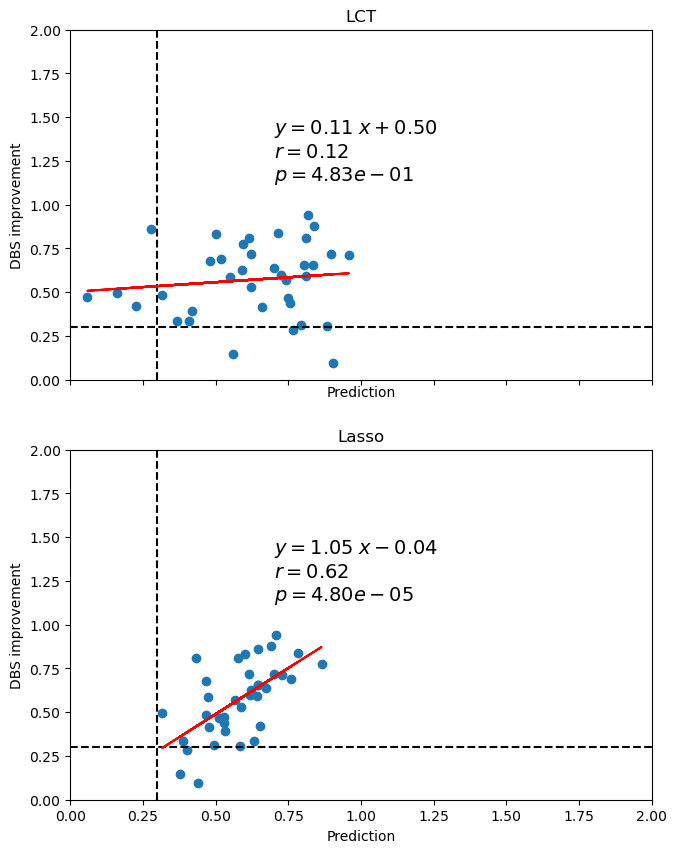

In [9]:
util.eval_prediction(np.vstack((np.repeat(pre_imp,r),
                               results_ls,
                               )),
                               np.repeat(per_change,r),
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')